In [41]:
# Import all necessary libraries for ViT and data processing
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import os
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [42]:
!pip install numpy matplotlib opencv-python seaborn sklearn scikit-learn


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

In [ ]:
# Constants
IMAGE_SIZE = 128
CHANNELS = 3
BATCH_SIZE = 32
PATCH_SIZE = 32
dataset_path = r'C:\Users\abdul\Downloads\Telegram Desktop\AugTomato\AugTomato'
MODEL_SAVE_PATH = 'vitMaize_model.weights.h5'

# Function to count total samples in dataset
def get_total_samples(dataset_path):
    """Count total image files in the dataset directory."""
    total_samples = 0
    for root, _, files in os.walk(dataset_path):
        total_samples += sum(1 for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg')))
    return total_samples

# Get total samples dynamically
total_samples = get_total_samples(dataset_path)
if total_samples == 0:
    raise ValueError("No images found in dataset.")
print(f"Total samples: {total_samples}")

# Load dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,  # 30% for validation+test
    subset="training",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Get class names before transformations
class_names = train_ds.class_names
print("Class names:", class_names)

val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Normalize images
train_ds = train_ds.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))
val_test_ds = val_test_ds.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))

# Calculate split sizes dynamically
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.2)
test_size = total_samples - train_size - val_size  # Ensure exact split
val_batches = val_size // BATCH_SIZE
test_batches = test_size // BATCH_SIZE

# Split validation and test datasets
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

# Cache and prefetch
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

# Verify dataset sizes
print(f"Training samples: {len(train_ds) * BATCH_SIZE} (~{train_size})")
print(f"Validation samples: {len(val_ds) * BATCH_SIZE} (~{val_size})")
print(f"Test samples: {len(test_ds) * BATCH_SIZE} (~{test_size})")

Total samples: 19200
Found 19200 files belonging to 12 classes.
Found 19200 files belonging to 12 classes.
Using 13440 files for training.
Using 13440 files for training.
Class names: ['Blossom_end_rot_d', 'TomL_Bacterial_floundering_d', 'TomL_Mite_d', 'TomL_alternaria_mite_d', 'TomL_fusarium_d', 'TomL_healthy_leaf', 'TomL_virosis_d', 'alternaria_d', 'exces_nitrogen_d', 'healthy_fruit', 'sunburn_d', 'tomato_late_blight_d']
Class names: ['Blossom_end_rot_d', 'TomL_Bacterial_floundering_d', 'TomL_Mite_d', 'TomL_alternaria_mite_d', 'TomL_fusarium_d', 'TomL_healthy_leaf', 'TomL_virosis_d', 'alternaria_d', 'exces_nitrogen_d', 'healthy_fruit', 'sunburn_d', 'tomato_late_blight_d']
Found 19200 files belonging to 12 classes.
Found 19200 files belonging to 12 classes.
Using 5760 files for validation.
Using 5760 files for validation.
Training samples: 13440 (~13440)
Validation samples: 3840 (~3840)
Test samples: 1920 (~1920)
Training samples: 13440 (~13440)
Validation samples: 3840 (~3840)
Test s

In [44]:
# class Patches(layers.Layer):
#     def __init__(self, patch_size):
#         super(Patches, self).__init__()
#         self.patch_size = patch_size
    
#     def call(self, images):
#         batch_size = tf.shape(images)[0]
#         patches = tf.image.extract_patches(
#             images=images,
#             sizes=[1, self.patch_size, self.patch_size, 1],
#             strides=[1, self.patch_size, self.patch_size, 1],
#             rates=[1, 1, 1, 1],
#             padding="VALID",
#         )
#         patch_dims = patches.shape[-1]
#         patches = tf.reshape(patches, [batch_size, -1, patch_dims])
#         return patches

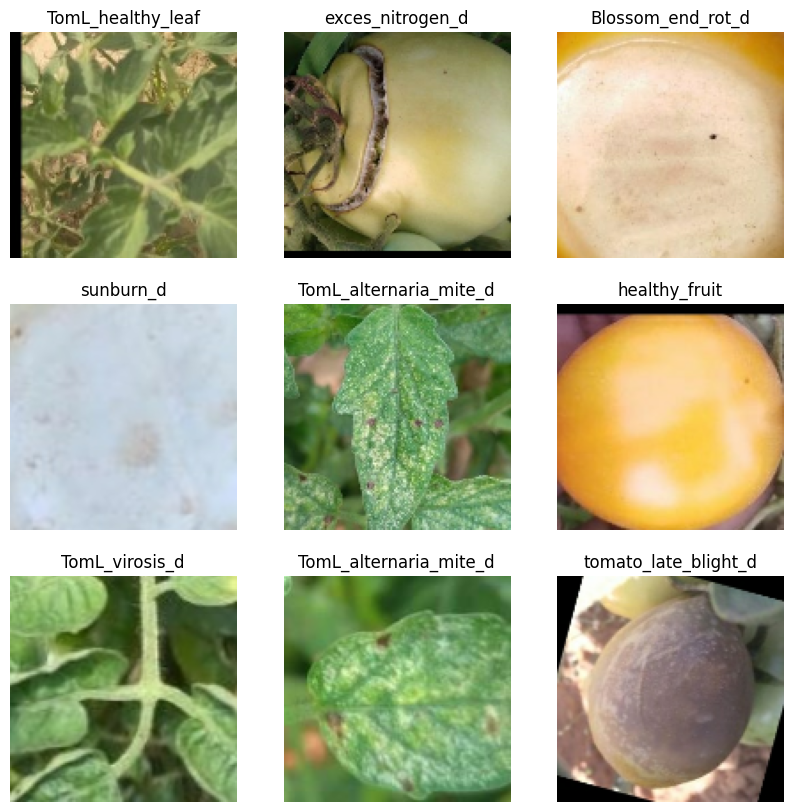

In [45]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

**Its worked properly**

In [46]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
from tensorflow.keras.layers import Layer
import tensorflow as tf
from tensorflow.keras import layers

class RepeatClassToken(Layer):
    def __init__(self, **kwargs):
        super(RepeatClassToken, self).__init__(**kwargs)
    
    def call(self, inputs):
        cls_token, x = inputs
        batch_size = tf.shape(x)[0]
        cls_token = tf.repeat(cls_token, repeats=batch_size, axis=0)
        return cls_token

class CustomMultiHeadAttention(Layer):
    def __init__(self, num_heads, key_dim, dropout=0.0, **kwargs):
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout)
    
    def call(self, query, value, **kwargs):
        output, attn_weights = self.mha(query, value, return_attention_scores=True)
        return output, attn_weights

def create_vit_model(input_shape, num_classes, patch_size=8, num_transformer_layers=6, num_heads=4, hidden_dim=128, use_patches_layer=True):
    """Create a Vision Transformer model for eye disease classification."""
    inputs = layers.Input(shape=input_shape)
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    if use_patches_layer:
        patches = Patches(patch_size)(inputs)
        x = layers.Dense(hidden_dim)(patches)
    else:
        patches = layers.Conv2D(filters=hidden_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
        patches = layers.Reshape((num_patches, hidden_dim))(patches)
        x = patches
    cls_token = layers.Dense(hidden_dim)(tf.zeros((1, 1, hidden_dim)))
    cls_token = RepeatClassToken()([cls_token, x])
    x = layers.Concatenate(axis=1)([cls_token, x])
    num_patches += 1
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embed = layers.Embedding(input_dim=num_patches, output_dim=hidden_dim)(positions)
    pos_embed = tf.expand_dims(pos_embed, axis=0)
    x = x + pos_embed
    last_attn_weights = None
    for _ in range(num_transformer_layers):
        x_norm = layers.LayerNormalization(epsilon=1e-6)(x)
        attn_layer = CustomMultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim, dropout=0.1)
        attn_output, attn_weights = attn_layer(x_norm, x_norm)
        attn_output = layers.Dropout(0.1)(attn_output)
        x = x + attn_output
        x_norm = layers.LayerNormalization(epsilon=1e-6)(x)
        ffn = layers.Dense(hidden_dim * 4, activation='gelu')(x_norm)
        ffn = layers.Dense(hidden_dim, activation='gelu')(ffn)
        ffn = layers.Dropout(0.1)(ffn)
        x = x + ffn
        last_attn_weights = attn_weights
    x = x[:, 0, :]
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs, outputs)
    model.last_attn_weights = last_attn_weights
    return model

In [47]:
# Create model
model = create_vit_model(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    num_classes=len(class_names),
    patch_size=PATCH_SIZE,
    num_transformer_layers=6,
    num_heads=4,
    hidden_dim=128,
    use_patches_layer=True
)

# Compile model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_2 (Patches) │ (None, None,      │          0 │ input_layer_1[0]… │
│                     │ 3072)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, None, 128) │    393,344 │ patches_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_class_token… │ (None, 1, 128)    │          0 │ dense_15[0][0]    │
│ (RepeatClassToken)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None, 128) │          0 │ repeat_class_tok… │
│ (Concatenate)       │                   │            │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 17, 128)   │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 17, 128)   │        256 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_multi_head_… │ [(None, 17, 128), │    263,808 │ layer_normalizat… │
│ (CustomMultiHeadAt… │ (None, 4, 17,     │            │ layer_normalizat… │
│                     │ 17)]              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 17, 128)   │          0 │ custom_multi_hea… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 17, 128)   │          0 │ add_13[0][0],     │
│                     │                   │            │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 17, 128)   │        256 │ add_14[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 17, 512)   │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 17, 128)   │     65,664 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 17, 128)   │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 17, 128)   │          0 │ add_14[0][0],     │
│                     │                   │            │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 17, 128)   │        256 │ add_15[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_multi_head_… │ [(None, 17, 128), │    263,808 │ layer_normalizat… │
│ (CustomMultiHeadAt… │ (None, 4, 17,     │            │ layer_normalizat… │
│                     │ 17)]              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,771,084 (10.57 MB)

 Trainable params: 2,771,084 (10.57 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# # Function to quickly train and evaluate different configurations
# def quick_train_and_evaluate(model, config_name, epochs=20):
#     """
#     Quick training function to test different ViT configurations
#     """
#     print(f"\n{'='*50}")
#     print(f"Training {config_name}")
#     print(f"{'='*50}")
    
#     # Create temporary save path
#     temp_save_path = f'vit_{config_name.lower().replace(" ", "_")}.weights.h5'
    
#     # Callbacks for quick training
#     checkpoint = ModelCheckpoint(
#         temp_save_path,
#         monitor='val_accuracy',
#         save_best_only=True,
#         mode='max',
#         verbose=1,
#         save_weights_only=True
#     )
#     early_stopping = EarlyStopping(
#         monitor='val_loss',
#         patience=8,  # Reduced for quick testing
#         restore_best_weights=True,
#         mode='auto'
#     )
#     lr_reducer = ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         cooldown=1,
#         patience=5,  # Reduced for quick testing
#         min_lr=1e-6,
#         verbose=1
#     )
    
#     # Train model
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=epochs,
#         callbacks=[checkpoint, early_stopping, lr_reducer],
#         verbose=1
#     )
    
#     # Load best weights and evaluate
#     model.load_weights(temp_save_path)
#     val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
#     test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
    
#     print(f"\n{config_name} Results:")
#     print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
#     print(f"Test Accuracy: {test_accuracy*100:.2f}%")
#     print(f"Model Parameters: {model.count_params():,}")
    
#     return {
#         'config_name': config_name,
#         'val_accuracy': val_accuracy,
#         'test_accuracy': test_accuracy,
#         'parameters': model.count_params(),
#         'history': history
#     }

# # Choose which configuration to train (uncomment one)
# print("Choose a configuration to train:")
# print("1. Configuration 1: Deeper Model (8 layers, 8 heads, 128 dim)")
# print("2. Configuration 2: Larger Hidden Dim (6 layers, 6 heads, 192 dim)")
# print("3. Configuration 3: Balanced Approach (8 layers, 6 heads, 192 dim)")  
# print("4. Configuration 4: Conservative (7 layers, 8 heads, 128 dim)")
# print("\nUncomment the desired configuration below to train:")

In [49]:
# Training different configurations
# Uncomment ONE of the following to train that configuration

# Option 1: Configuration 1 (Deeper Model - Recommended for stability)
# results_1 = quick_train_and_evaluate(model_config1, "Config 1: Deeper Model", epochs=30)

# Option 2: Configuration 2 (Larger Hidden Dimension)
# results_2 = quick_train_and_evaluate(model_config2, "Config 2: Larger Hidden Dim", epochs=30)

# Option 3: Configuration 3 (Balanced Approach - Recommended for best results)
# results_3 = quick_train_and_evaluate(model_config3, "Config 3: Balanced Approach", epochs=30)

# Option 4: Configuration 4 (Conservative Improvement - Safest upgrade)
# results_4 = quick_train_and_evaluate(model_config4, "Config 4: Conservative", epochs=30)

# To train all configurations (will take longer):
# all_results = []
# all_results.append(quick_train_and_evaluate(model_config1, "Config 1", epochs=25))
# all_results.append(quick_train_and_evaluate(model_config2, "Config 2", epochs=25))
# all_results.append(quick_train_and_evaluate(model_config3, "Config 3", epochs=25))
# all_results.append(quick_train_and_evaluate(model_config4, "Config 4", epochs=25))

In [50]:
# # Experiment with different ViT configurations
# # Current: 97.50% accuracy with 6 layers, 4 heads, 128 hidden_dim

# # Configuration 1: Deeper model with more heads (recommended for your image size)
# print("=== Configuration 1: Deeper Model ===")
# model_config1 = create_vit_model(
#     input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
#     num_classes=len(class_names),
#     patch_size=PATCH_SIZE,
#     num_transformer_layers=8,  # Increased from 6
#     num_heads=8,               # Increased from 4 (should divide hidden_dim evenly)
#     hidden_dim=128,            # Keep same
#     use_patches_layer=True
# )
# model_config1.compile(
#     optimizer="adam",
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=["accuracy"]
# )
# print(f"Model 1 parameters: {model_config1.count_params():,}")

# # Configuration 2: Larger hidden dimension with proportional heads
# print("\n=== Configuration 2: Larger Hidden Dimension ===")
# model_config2 = create_vit_model(
#     input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
#     num_classes=len(class_names),
#     patch_size=PATCH_SIZE,
#     num_transformer_layers=6,  # Keep same
#     num_heads=6,               # Adjusted for 192 hidden_dim (192/6=32)
#     hidden_dim=192,            # Increased from 128
#     use_patches_layer=True
# )
# model_config2.compile(
#     optimizer="adam",
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=["accuracy"]
# )
# print(f"Model 2 parameters: {model_config2.count_params():,}")

# # Configuration 3: Balanced approach (recommended)
# print("\n=== Configuration 3: Balanced Approach ===")
# model_config3 = create_vit_model(
#     input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
#     num_classes=len(class_names),
#     patch_size=PATCH_SIZE,
#     num_transformer_layers=8,  # More layers
#     num_heads=6,               # More heads
#     hidden_dim=192,            # Larger embedding
#     use_patches_layer=True
# )
# model_config3.compile(
#     optimizer="adam",
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=["accuracy"]
# )
# print(f"Model 3 parameters: {model_config3.count_params():,}")

# # Configuration 4: Conservative improvement
# print("\n=== Configuration 4: Conservative Improvement ===")
# model_config4 = create_vit_model(
#     input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
#     num_classes=len(class_names),
#     patch_size=PATCH_SIZE,
#     num_transformer_layers=7,  # Slightly more layers
#     num_heads=8,               # More heads (128/8=16)
#     hidden_dim=128,            # Keep same
#     use_patches_layer=True
# )
# model_config4.compile(
#     optimizer="adam",
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=["accuracy"]
# )
# print(f"Model 4 parameters: {model_config4.count_params():,}")

# print("\n=== Original Model (for comparison) ===")
# print(f"Original model parameters: {model.count_params():,}")

# # Summary of configurations
# print("\n" + "="*60)
# print("CONFIGURATION SUMMARY:")
# print("="*60)
# print("Config 1: 8 layers, 8 heads, 128 hidden_dim - Focus on depth + attention")
# print("Config 2: 6 layers, 6 heads, 192 hidden_dim - Focus on representation")  
# print("Config 3: 8 layers, 6 heads, 192 hidden_dim - Balanced improvement")
# print("Config 4: 7 layers, 8 heads, 128 hidden_dim - Conservative upgrade")
# print("Original: 6 layers, 4 heads, 128 hidden_dim - Current 97.50%")
# print("="*60)

**Leightweight ViT**

In [51]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# # Patch extraction
# class Patches(layers.Layer):
#     def __init__(self, patch_size):
#         super().__init__()
#         self.patch_size = patch_size

#     def call(self, images):
#         batch_size = tf.shape(images)[0]
#         patches = tf.image.extract_patches(
#             images=images,
#             sizes=[1, self.patch_size, self.patch_size, 1],
#             strides=[1, self.patch_size, self.patch_size, 1],
#             rates=[1, 1, 1, 1],
#             padding="VALID"
#         )
#         patch_dim = patches.shape[-1]
#         return tf.reshape(patches, [batch_size, -1, patch_dim])

# # Positional embedding
# class AddPositionEmbedding(layers.Layer):
#     def __init__(self, num_patches, projection_dim):
#         super().__init__()
#         self.pos_emb = self.add_weight(
#             name="pos_emb",
#             shape=[1, num_patches, projection_dim],
#             initializer="random_normal",
#             trainable=True
#         )

#     def call(self, x):
#         return x + self.pos_emb

# # Class token
# class RepeatClassToken(layers.Layer):
#     def __init__(self):
#         super().__init__()

#     def build(self, input_shape):
#         dim = input_shape[-1]
#         self.cls_token = self.add_weight(
#             shape=(1, 1, dim),
#             initializer="random_normal",
#             trainable=True,
#             name="cls_token"
#         )

#     def call(self, x):
#         batch_size = tf.shape(x)[0]
#         return tf.repeat(self.cls_token, repeats=batch_size, axis=0)

# # MLP
# def mlp(x, hidden_units, dropout_rate, output_dim=None):
#     for units in hidden_units:
#         x = layers.Dense(units, activation=tf.nn.gelu)(x)
#         x = layers.Dropout(dropout_rate)(x)
#     if output_dim is not None:
#         x = layers.Dense(output_dim)(x)
#     return x

# # Lightweight ViT
# def create_light_vit(
#     input_shape=(128, 128, 3),
#     patch_size=8,
#     projection_dim=64,
#     transformer_layers=4,
#     num_heads=2,
#     mlp_head_units=[64],
#     dropout_rate=0.1,
#     num_classes=len(class_names),
# ):
#     inputs = layers.Input(shape=input_shape)
#     num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

#     # Patch projection
#     patches = Patches(patch_size)(inputs)
#     x = layers.Dense(projection_dim)(patches)

#     # Class token and positional encoding
#     cls_tokens = RepeatClassToken()(x)
#     x = layers.Concatenate(axis=1)([cls_tokens, x])
#     x = AddPositionEmbedding(num_patches + 1, projection_dim)(x)

#     # Transformer Encoder Blocks
#     for _ in range(transformer_layers):
#         # Self-attention block
#         attn_out = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x, x)
#         x = layers.Add()([x, attn_out])
#         x = layers.LayerNormalization(epsilon=1e-6)(x)

#         # Feed-forward block
#         ffn_out = mlp(x, hidden_units=[projection_dim * 2], dropout_rate=dropout_rate, output_dim=projection_dim)
#         x = layers.Add()([x, ffn_out])
#         x = layers.LayerNormalization(epsilon=1e-6)(x)

#     # Classification head
#     x = x[:, 0, :]
#     for units in mlp_head_units:
#         x = layers.Dense(units, activation='gelu')(x)
#         x = layers.Dropout(dropout_rate)(x)
#     outputs = layers.Dense(num_classes, activation='softmax')(x)

#     return models.Model(inputs, outputs)
# model = create_light_vit(
#     input_shape=(128, 128, 3),
#     patch_size=8,
#     projection_dim=64,
#     transformer_layers=4,
#     num_heads=2,
#     mlp_head_units=[64],
#     dropout_rate=0.1,
#     num_classes=len(class_names)
# )
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.0),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # <- Fix here
#     metrics=['accuracy']
# )

# model.summary()

In [52]:
# # Generate a detailed model summary plot
# from tensorflow.keras.utils import plot_model

# plot_model(model, to_file='vit_architecture.png', 
#            show_shapes=True,
#            show_layer_names=True,
#            rankdir='TB',
#            expand_nested=True,
#            dpi=96)

# # Display the image
# plt.figure(figsize=(20, 20))
# img = plt.imread('vit_architecture.png')
# plt.imshow(img)
# plt.axis('off')
# plt.title('Vision Transformer Architecture', pad=20)
# plt.show()

In [53]:
# !pip install visualkeras
# import visualkeras

# from tensorflow.keras.utils import plot_model
# from visualkeras import layered_view

# # Create the model (using your function)
# # model = create_vit_model(input_shape=(256,256, 3), num_classes=10)  # example params

# # Generate visualization
# layered_view(model, legend=True, draw_volume=False).show()

In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# Define callbacks
checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_weights_only=True
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    mode='auto'
)
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    cooldown=2,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[checkpoint, early_stopping, lr_reducer],
    verbose=1
)

# Load best weights
model.load_weights(MODEL_SAVE_PATH)

Epoch 1/100
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2337 - loss: 2.2325
Epoch 1: val_accuracy improved from None to 0.29427, saving model to vitTomatoo_model.weights.h5

Epoch 1: val_accuracy improved from None to 0.29427, saving model to vitTomatoo_model.weights.h5
420/420 ━━━━━━━━━━━━━━━━━━━━ 77s 151ms/step - accuracy: 0.3175 - loss: 1.9538 - val_accuracy: 0.2943 - val_loss: 1.9881 - learning_rate: 1.0000e-04
Epoch 2/100
420/420 ━━━━━━━━━━━━━━━━━━━━ 77s 151ms/step - accuracy: 0.3175 - loss: 1.9538 - val_accuracy: 0.2943 - val_loss: 1.9881 - learning_rate: 1.0000e-04
Epoch 2/100
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4521 - loss: 1.5163
Epoch 2: val_accuracy improved from 0.29427 to 0.57552, saving model to vitTomatoo_model.weights.h5

Epoch 2: val_accuracy improved from 0.29427 to 0.57552, saving model to vitTomatoo_model.weights.h5
420/420 ━━━━━━━━━━━━━━━━━━━━ 50s 119ms/step - accuracy: 0.4959 - loss: 1.4069 - val_accuracy: 0.5755 - val_loss: 1.221

Test accuracy: 0.9583


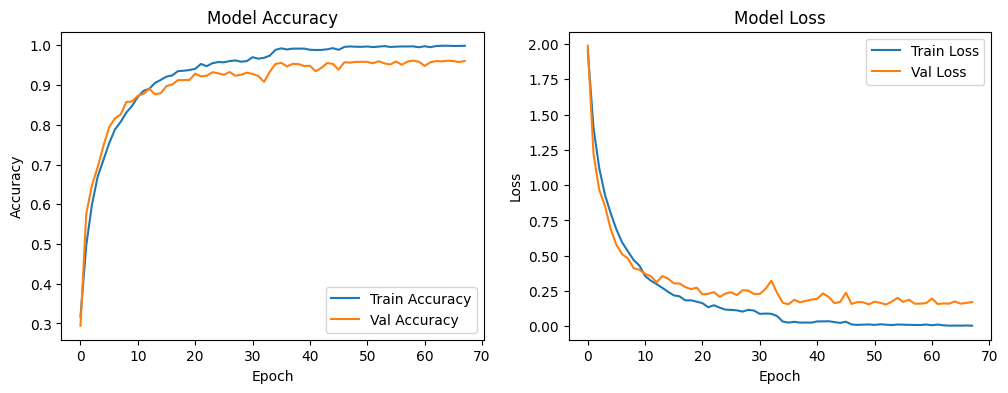

In [55]:
# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9583 - loss: 0.1795
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9583 - loss: 0.1795
Test Accuracy: 95.83%



In [57]:
# Evaluate model on test set
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9615 - loss: 0.1611
Validation Accuracy: 96.15%
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9615 - loss: 0.1611
Validation Accuracy: 96.15%


In [58]:
!pip install tqdm


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Predicting on test set: 100%|██████████| 60/60 [00:06<00:00,  9.99it/s]



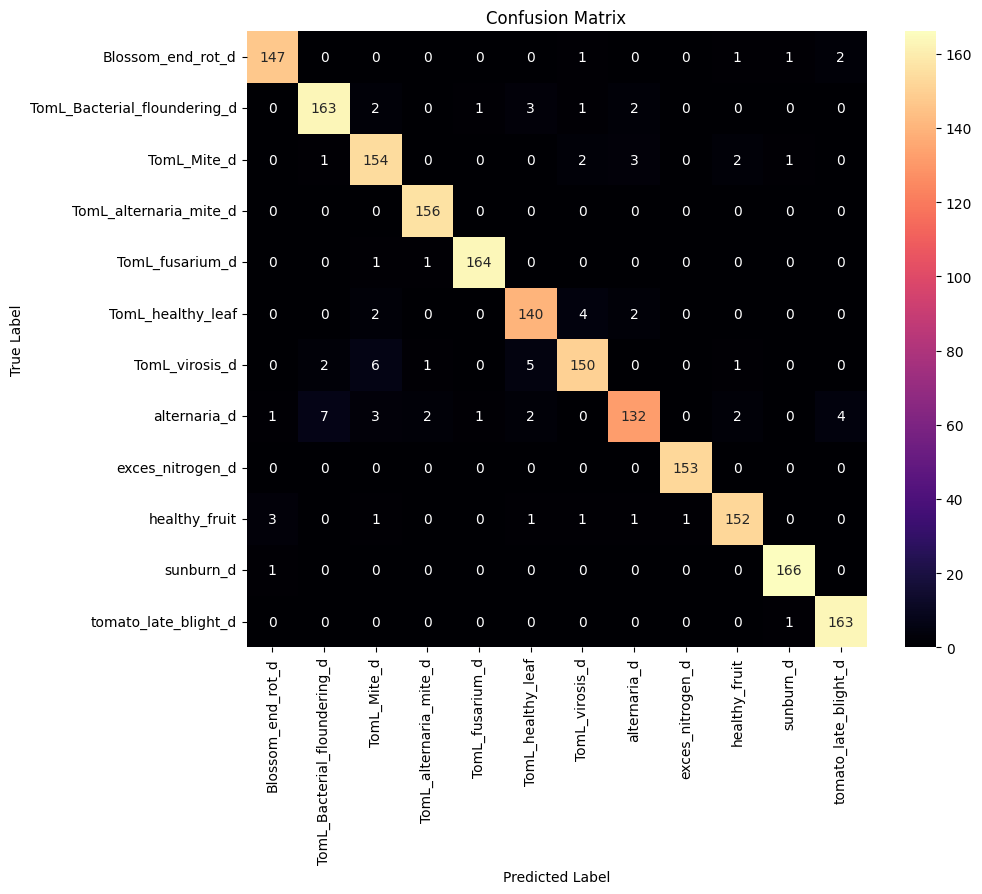

Classification Report:
                              precision    recall  f1-score   support

           Blossom_end_rot_d       0.97      0.97      0.97       152
TomL_Bacterial_floundering_d       0.94      0.95      0.94       172
                 TomL_Mite_d       0.91      0.94      0.93       163
      TomL_alternaria_mite_d       0.97      1.00      0.99       156
             TomL_fusarium_d       0.99      0.99      0.99       166
           TomL_healthy_leaf       0.93      0.95      0.94       148
              TomL_virosis_d       0.94      0.91      0.93       165
                alternaria_d       0.94      0.86      0.90       154
            exces_nitrogen_d       0.99      1.00      1.00       153
               healthy_fruit       0.96      0.95      0.96       160
                   sunburn_d       0.98      0.99      0.99       167
        tomato_late_blight_d       0.96      0.99      0.98       164

                    accuracy                           0.96      

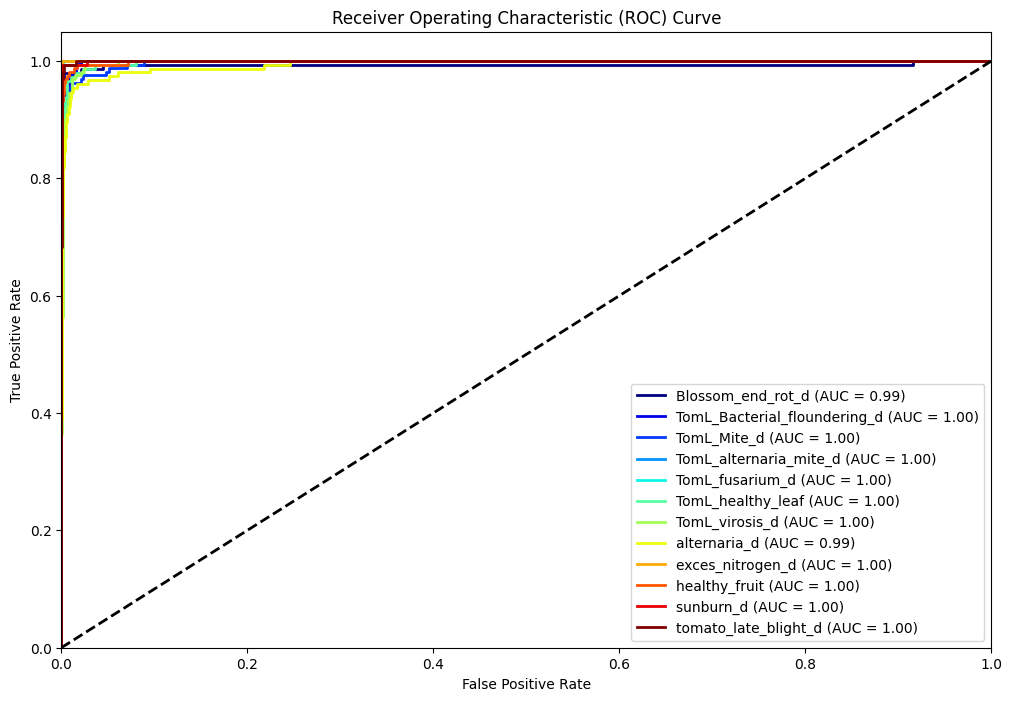

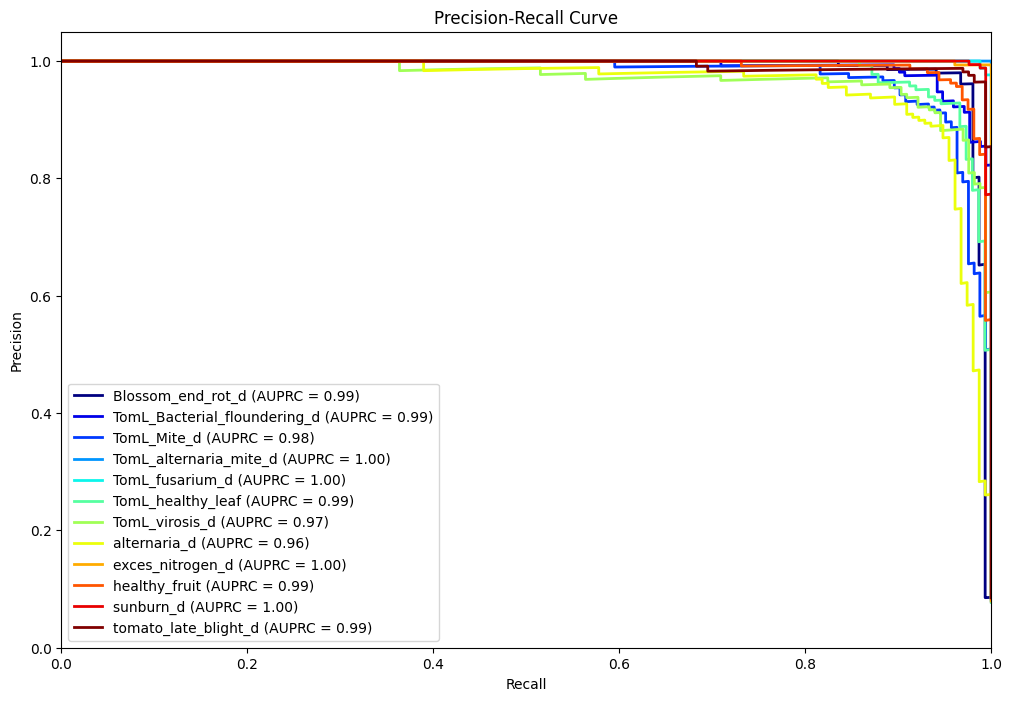

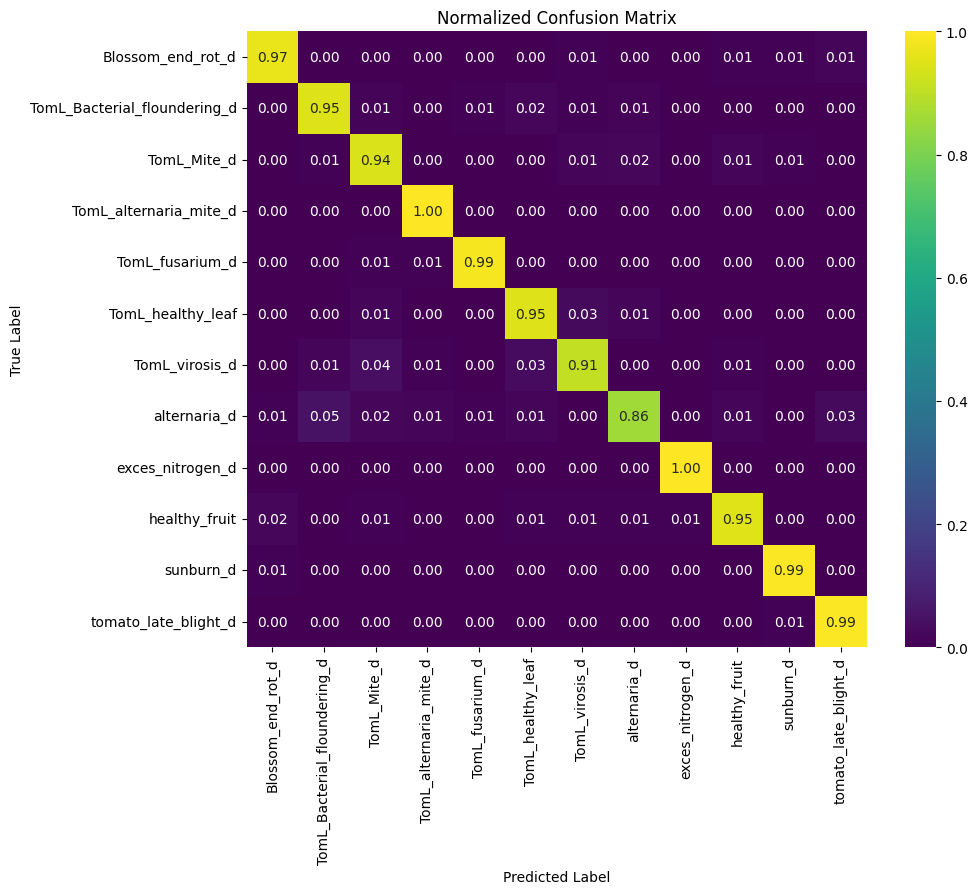

C:\Users\abdul\AppData\Local\Temp\ipykernel_22052\221631092.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=class_names, y=class_accuracy, palette='mako')


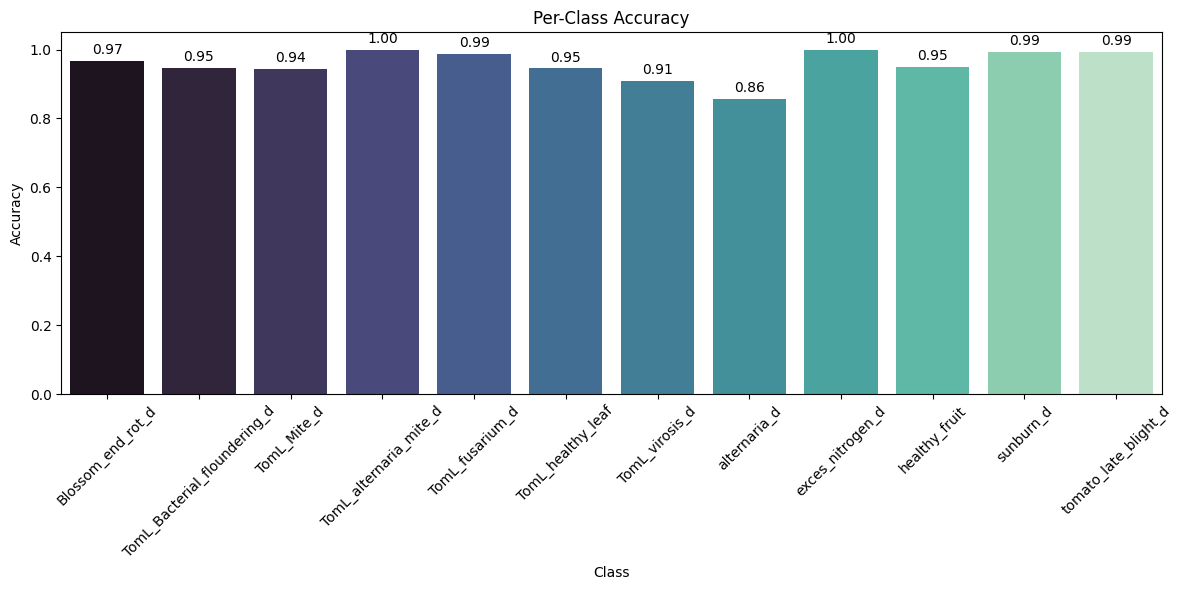

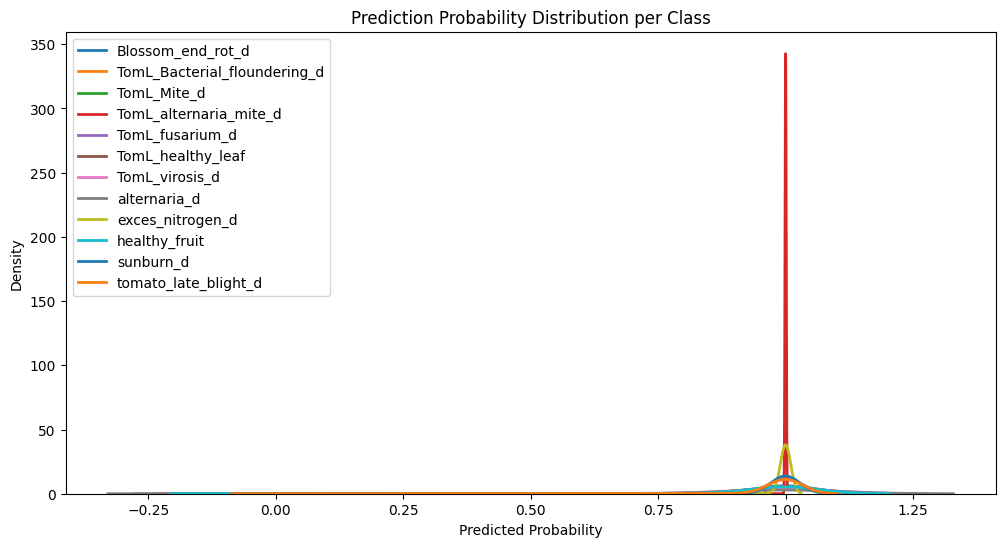

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, cohen_kappa_score
from tqdm import tqdm

# Collect predictions for confusion matrix and other metrics
y_true = []
y_pred = []
y_pred_proba = []
for images, labels in tqdm(test_ds, desc="Predicting on test set"):
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
    y_pred_proba.extend(predictions)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Compute Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")

# Compute and plot ROC curves
y_true_binary = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_names)):
    if np.sum(y_true_binary[:, i]) == 0:
        print(f"Warning: Class {class_names[i]} has no samples in test set, skipping ROC.")
        continue
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
colors = plt.cm.jet(np.linspace(0, 1, len(class_names)))
for i, color in zip(range(len(class_names)), colors):
    if i in fpr:
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Compute and plot Precision-Recall curves (AUPRC)
precision = {}
recall = {}
pr_auc = {}
for i in range(len(class_names)):
    if np.sum(y_true_binary[:, i]) == 0:
        print(f"Warning: Class {class_names[i]} has no samples in test set, skipping PR curve.")
        continue
    precision[i], recall[i], _ = precision_recall_curve(y_true_binary[:, i], y_pred_proba[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

plt.figure(figsize=(12, 8))
for i, color in zip(range(len(class_names)), colors):
    if i in precision:
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUPRC = {pr_auc[i]:0.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Plot normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

# Plot class-wise accuracy with text annotations
class_accuracy = cm.diagonal() / cm.sum(axis=1)
class_accuracy = np.nan_to_num(class_accuracy)  # Replace NaN with 0
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=class_names, y=class_accuracy, palette='mako')
for i, acc in enumerate(class_accuracy):
    barplot.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom')
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.tight_layout()
plt.show()

# Plot prediction probability distribution
plt.figure(figsize=(12, 6))
for i in range(len(class_names)):
    sns.kdeplot(y_pred_proba[y_true == i, i], label=class_names[i], linewidth=2)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Prediction Probability Distribution per Class')
plt.legend()
plt.show()

Predicting on test set: 100%|██████████| 60/60 [00:05<00:00, 11.27it/s]

C:\Users\abdul\AppData\Local\Temp\ipykernel_22052\3921846401.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Classification', y='Pixel Intensity', data=data, palette='Set2')
C:\Users\abdul\AppData\Local\Temp\ipykernel_22052\3921846401.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Classification', y='Pixel Intensity', data=data, palette='Set2')


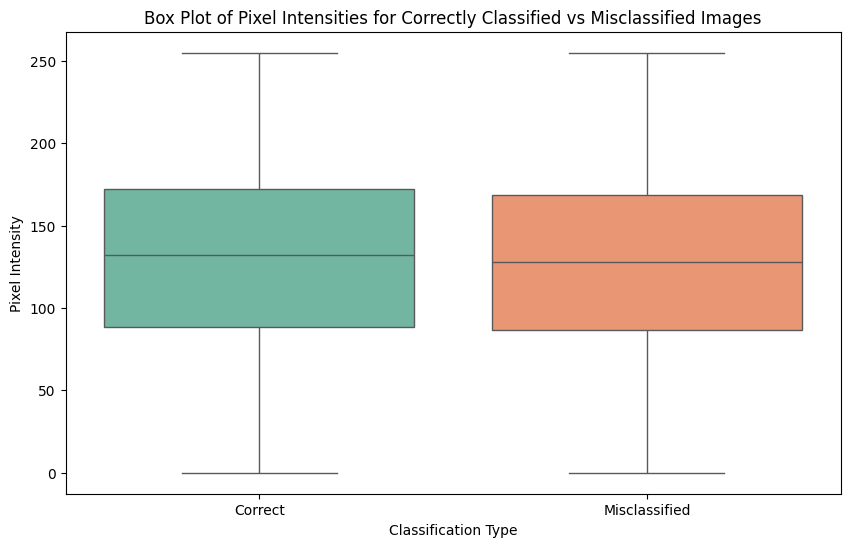

Box Plot Statistics:
                    count        mean        std  min        25%         50%  \
Classification                                                                 
Correct         4915200.0  127.981979  59.290546  0.0  88.371338  131.939629   
Misclassified   3932160.0  125.824951  58.861301  0.0  86.548889  127.882652   

                       75%    max  
Classification                     
Correct         172.474037  255.0  
Misclassified   168.860283  255.0  


In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Collect all images, true labels, and predictions
all_images = []
y_true = []
y_pred = []
y_pred_proba = []
for images, labels in tqdm(test_ds, desc="Predicting on test set"):
    predictions = model.predict(images, verbose=0)
    all_images.extend(images.numpy())
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
    y_pred_proba.extend(predictions)
all_images = np.array(all_images)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Identify correctly classified and misclassified images
correct_indices = np.where(y_true == y_pred)[0]
misclassified_indices = np.where(y_true != y_pred)[0]

# Extract pixel intensities for correctly classified images
correct_images = [all_images[i].flatten() * 255 for i in correct_indices[:min(100, len(correct_indices))]]  # Limit to 100 for performance
correct_intensities = np.concatenate(correct_images) if correct_images else np.array([])

# Extract pixel intensities for misclassified images
misclassified_images = [all_images[i].flatten() * 255 for i in misclassified_indices[:min(100, len(misclassified_indices))]]  # Limit to 100 for performance
misclassified_intensities = np.concatenate(misclassified_images) if misclassified_images else np.array([])

# Create a DataFrame for box plot
data = pd.DataFrame({
    'Pixel Intensity': np.concatenate([correct_intensities, misclassified_intensities]),
    'Classification': ['Correct'] * len(correct_intensities) + ['Misclassified'] * len(misclassified_intensities)
})

# Plot box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Classification', y='Pixel Intensity', data=data, palette='Set2')
plt.title('Box Plot of Pixel Intensities for Correctly Classified vs Misclassified Images')
plt.xlabel('Classification Type')
plt.ylabel('Pixel Intensity')
plt.show()

# Calculate and print box plot statistics
stats = data.groupby('Classification')['Pixel Intensity'].describe()
print("Box Plot Statistics:")
print(stats)

In [61]:
# Example code to generate the table dynamically (not wrapped in <xaiArtifact> as it's explanatory)
train_acc = history.history['accuracy'][-1] * 100
val_acc = history.history['val_accuracy'][-1] * 100
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
test_acc *= 100
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

table = f"| Metric            | Train       | Validation  | Test        |\n|--------------------|-------------|-------------|-------------|\n| Accuracy (%)       | {train_acc:.2f}       | {val_acc:.2f}       | {test_acc:.2f}       |\n| Loss               | {train_loss:.3f}       | {val_loss:.3f}       | {test_loss:.3f}       |"
print(table)

| Metric            | Train       | Validation  | Test        |
|--------------------|-------------|-------------|-------------|
| Accuracy (%)       | 99.87       | 96.07       | 95.83       |
| Loss               | 0.005       | 0.172       | 0.179       |


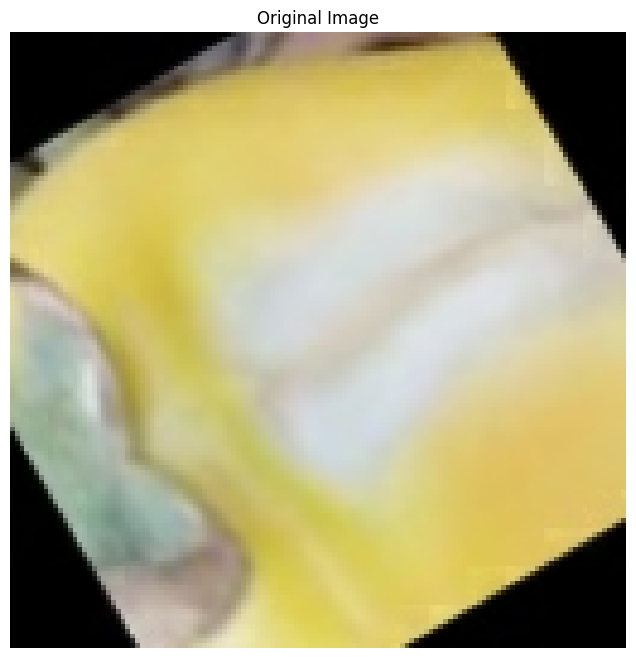

Image size: 128 X 128
Patch size: 32 X 32
Patches per image: 16
Elements per patch: 3072


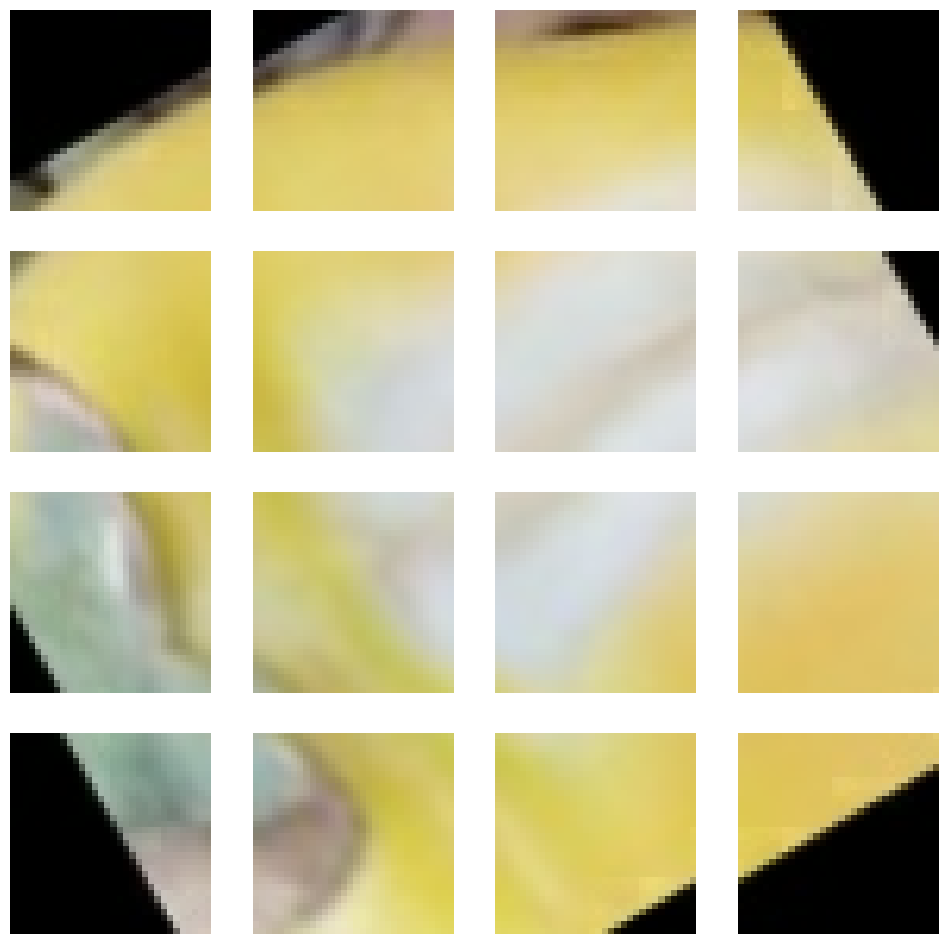

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Take one batch from the test dataset
for images, _ in train_ds.take(1):
    image = images[0]  # Select the first image in the batch
    break

# Display the original image
plt.figure(figsize=(8, 8))
plt.imshow(image.numpy(), cmap='gray')  # Grayscale image
plt.title("Original Image")
plt.axis("off")
plt.show()

# Resize and extract patches
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)
patches = Patches(PATCH_SIZE)(resized_image)
num_patches = patches.shape[1]  # Should be 1024 for RGB, 256 for grayscale
patch_dims = patches.shape[-1]  # Should be 64 (8*8) for grayscale or 192 for RGB

print(f"Image size: {IMAGE_SIZE} X {IMAGE_SIZE}")
print(f"Patch size: {PATCH_SIZE} X {PATCH_SIZE}")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch: {patch_dims}")

# Visualize patches as a grid
n = int(np.sqrt(num_patches))  # e.g., sqrt(1024) = 32
plt.figure(figsize=(12, 12))  # Larger figure for 32x32 grid
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, CHANNELS))  # 1 channel for grayscale
    plt.imshow(patch_img.numpy(), cmap='gray')
    plt.axis("off")

In [63]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import layers

def get_attention_heatmap(model, image, patch_size=8, num_patches=1024):
    """Extract attention heatmap from ViT's last attention layer."""
    attn_model = tf.keras.Model(inputs=model.input, outputs=[model.last_attn_weights, model.output])
    image = tf.expand_dims(image, axis=0)
    attn_weights, _ = attn_model(image)
    if attn_weights is None:
        raise ValueError("Attention weights not available. Ensure model.last_attn_weights is set.")
    attn_weights = tf.reduce_mean(attn_weights, axis=1)
    attn_weights = attn_weights[0, 1:, 1:]
    attn_weights = tf.reduce_mean(attn_weights, axis=1)
    heatmap = tf.reshape(attn_weights, (32, 32))
    heatmap = tf.image.resize(heatmap[:, :, tf.newaxis], (IMAGE_SIZE, IMAGE_SIZE))[:, :, 0]
    heatmap = (heatmap - tf.reduce_min(heatmap)) / (tf.reduce_max(heatmap) - tf.reduce_min(heatmap) + 1e-10)
    return heatmap.numpy()

# def pseudo_segmentation(image):
#     """Apply pseudo-segmentation to highlight potential diseased areas."""
#     hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#     lower_red = np.array([0, 50, 50])
#     upper_red = np.array([10, 255, 255])
#     mask1 = cv2.inRange(hsv, lower_red, upper_red)
#     lower_red = np.array([170, 50, 50])
#     upper_red = np.array([180, 255, 255])
#     mask2 = cv2.inRange(hsv, lower_red, upper_red)
#     lower_yellow = np.array([15, 50, 50])
#     upper_yellow = np.array([35, 255, 255])
#     mask3 = cv2.inRange(hsv, lower_yellow, upper_yellow)
#     mask = mask1 + mask2 + mask3
#     kernel = np.ones((5, 5), np.uint8)
#     mask = cv2.dilate(mask, kernel, iterations=2)
#     return mask

def pseudo_segmentation(image):
    """Apply pseudo-segmentation to highlight potential diseased areas (e.g., lesions, hemorrhages)."""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # Target red lesions (hemorrhages)
    lower_red = np.array([0, 100, 80])
    upper_red = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)
    lower_red = np.array([170, 100, 80])
    upper_red = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv, lower_red, upper_red)
    # Target yellow/white exudates
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    mask3 = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask = mask1 + mask2 + mask3
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=2)
    return mask

def get_segmentation_metrics(image, mask):
    """Calculate metrics for pseudo-segmented diseased areas."""
    total_pixels = image.shape[0] * image.shape[1]
    diseased_pixels = np.sum(mask > 0)
    area_percent = (diseased_pixels / total_pixels) * 100
    masked_image = image.copy()
    masked_image[mask == 0] = 0
    mean_rgb = np.mean(masked_image[mask > 0], axis=0) if diseased_pixels > 0 else [0, 0, 0]
    return area_percent, mean_rgb

def visualize_predictions(model, test_ds, class_names, num_images=9, segment=False, highlight_disease=True):
    """Visualize model predictions with detailed diseased region metrics."""
    healthy_class = [name for name in class_names if 'normal' in name.lower() or 'healthy' in name.lower()]
    unhealthy_classes = [name for name in class_names if name not in healthy_class]
    plt.figure(figsize=(15, 5 * num_images))
    images_shown = 0
    
    for images, labels in test_ds.take(num_images // len(test_ds) + 1):
        predictions = model.predict(images, verbose=0)
        pred_labels = np.argmax(predictions, axis=1)
        
        for i in range(len(images)):
            if images_shown >= num_images:
                break
            
            image = images[i].numpy() * 255 if images[i].numpy().max() <= 1.0 else images[i].numpy()
            image = image.astype(np.uint8)
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[pred_labels[i]]
            is_unhealthy = pred_label in unhealthy_classes
            
            probs = predictions[i]
            top3_idx = np.argsort(probs)[-3:][::-1]
            top3_probs = [f"{class_names[idx]}: {probs[idx]*100:.1f}%" for idx in top3_idx]
            prob_text = "\n".join(top3_probs)
            
            ax = plt.subplot(num_images, 3 if segment and is_unhealthy else 2, images_shown * (3 if segment and is_unhealthy else 2) + 1)
            plt.imshow(image)
            plt.title(f"True: {true_label}\nPred: {pred_label}\n{prob_text}")
            plt.axis("off")
            
            try:
                heatmap = get_attention_heatmap(model, images[i], patch_size=8)
                ax = plt.subplot(num_images, 3 if segment and is_unhealthy else 2, images_shown * (3 if segment and is_unhealthy else 2) + 2)
                plt.imshow(image, alpha=0.6)
                plt.imshow(heatmap, cmap='jet', alpha=0.6)
                plt.title("Attention Heatmap")
                plt.axis("off")
            except Exception as e:
                print(f"Heatmap error for image {i}: {e}")
            
            if segment and is_unhealthy:
                mask = pseudo_segmentation(image)
                area_percent, mean_rgb = get_segmentation_metrics(image, mask)
                masked_image = image.copy()
                masked_image[mask == 0] = 0
                ax = plt.subplot(num_images, 3, images_shown * 3 + 3)
                plt.imshow(masked_image)
                plt.title(f"Pseudo-Segmented Disease\nArea: {area_percent:.1f}%\nMean RGB: ({mean_rgb[0]:.0f}, {mean_rgb[1]:.0f}, {mean_rgb[2]:.0f})")
                plt.axis("off")
            
            images_shown += 1
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)  # Increased vertical spacing between subplots
    plt.show()

Heatmap error for image 0: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 16 values, but the requested shape has 1024 [Op:Reshape]
Heatmap error for image 1: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 16 values, but the requested shape has 1024 [Op:Reshape]
Heatmap error for image 2: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 16 values, but the requested shape has 1024 [Op:Reshape]
Heatmap error for image 3: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 16 values, but the requested shape has 1024 [Op:Reshape]
Heatmap error for image 4: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 16 values, but the req

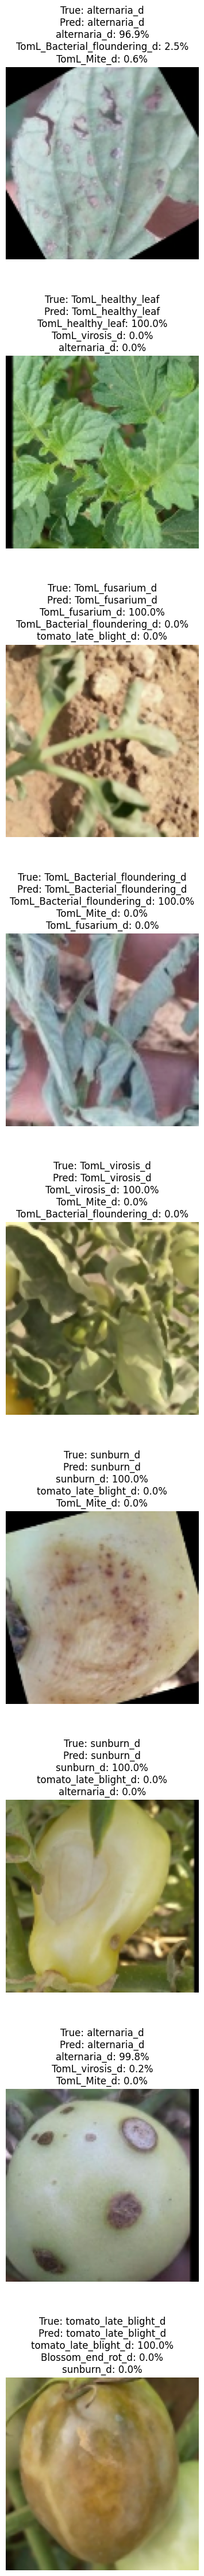

In [64]:
# Run visualizations
visualize_predictions(model, test_ds, class_names, num_images=9, segment=False)

Heatmap error for image 0: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 16 values, but the requested shape has 1024 [Op:Reshape]
Heatmap error for image 1: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 16 values, but the requested shape has 1024 [Op:Reshape]
Heatmap error for image 2: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 16 values, but the requested shape has 1024 [Op:Reshape]
Heatmap error for image 3: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 16 values, but the requested shape has 1024 [Op:Reshape]
Heatmap error for image 3: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 16 values, but the req

C:\Users\abdul\AppData\Local\Temp\ipykernel_22052\2417348200.py:121: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


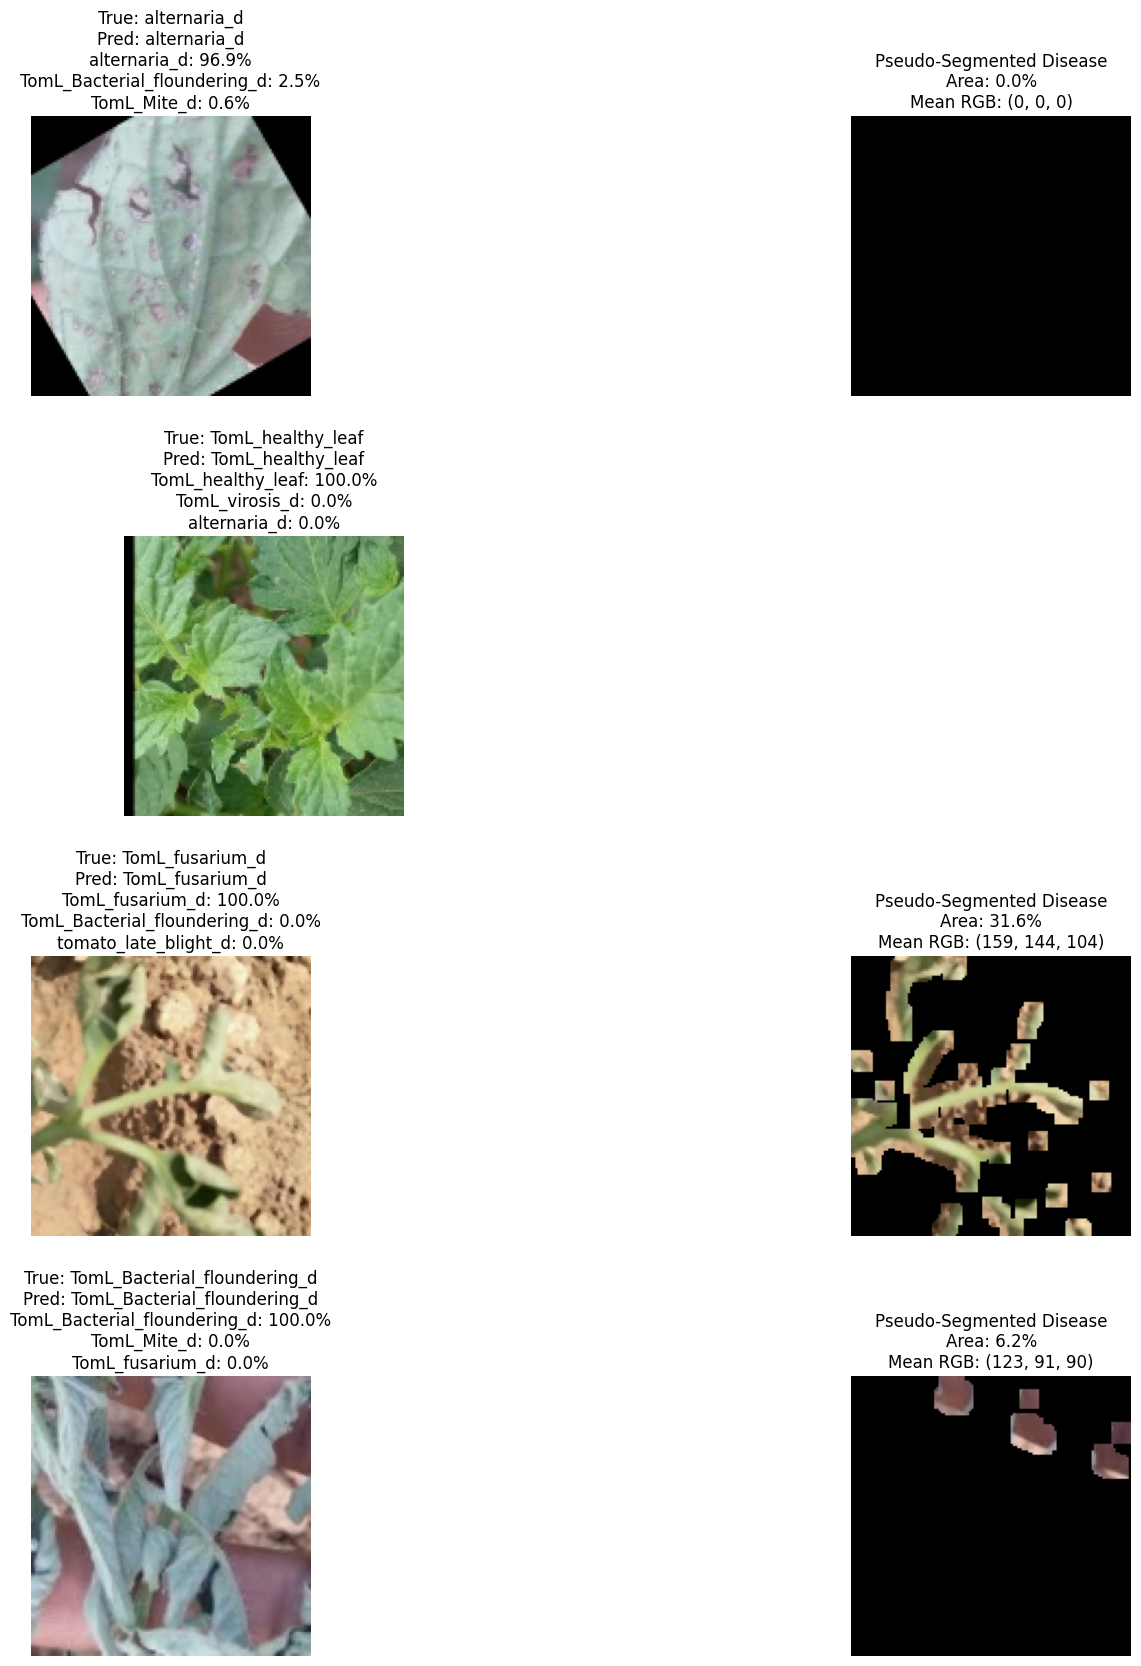

In [65]:
visualize_predictions(model, test_ds, class_names, num_images=4, segment=True)

Heatmap error for image 0: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 16 values, but the requested shape has 1024 [Op:Reshape]
Heatmap error for image 1: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 16 values, but the requested shape has 1024 [Op:Reshape]
Heatmap error for image 2: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 16 values, but the requested shape has 1024 [Op:Reshape]
Heatmap error for image 3: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 16 values, but the requested shape has 1024 [Op:Reshape]
Heatmap error for image 3: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 16 values, but the req

C:\Users\abdul\AppData\Local\Temp\ipykernel_22052\2417348200.py:121: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


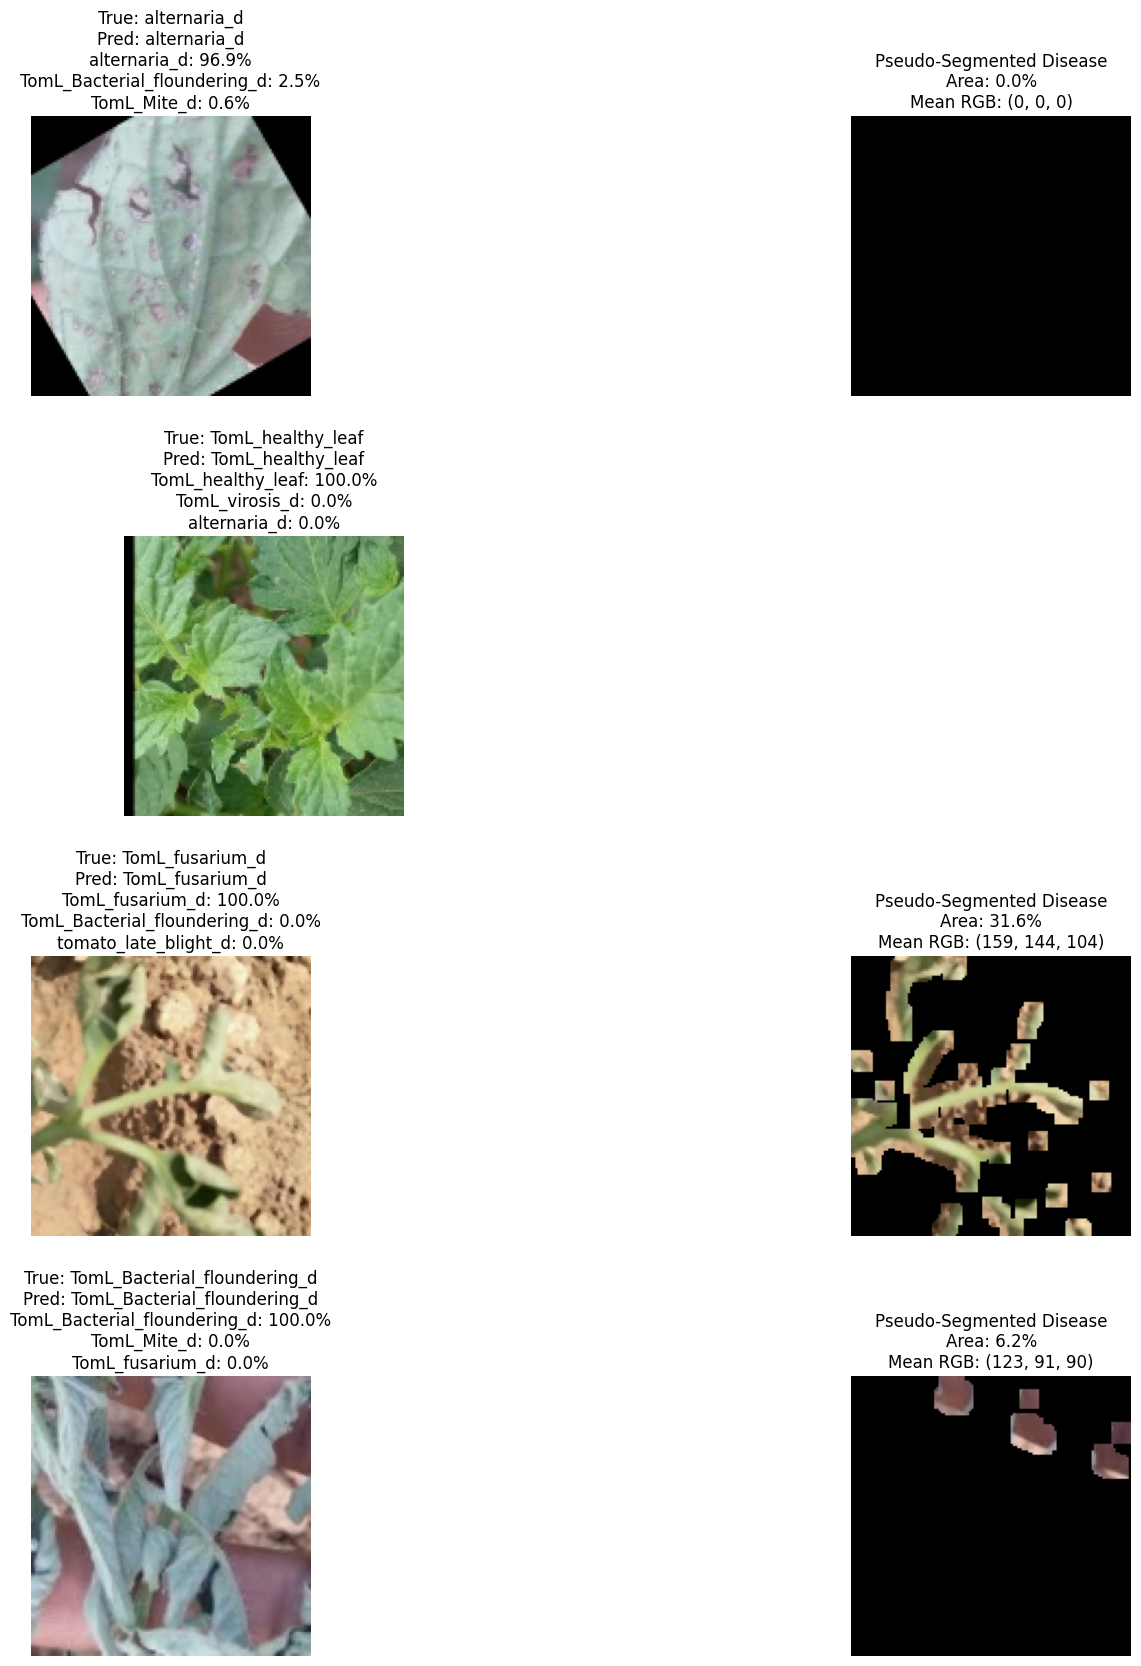

In [66]:
visualize_predictions(model, test_ds, class_names, num_images=4, segment=True)

In [67]:
# Evaluate model on test set
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9615 - loss: 0.1611
Validation Accuracy: 96.15%
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9615 - loss: 0.1611
Validation Accuracy: 96.15%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Image 1 Actual class: alternaria_d, Predicted class: TomL_virosis_d
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image 1 Actual class: alternaria_d, Predicted class: TomL_virosis_d
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image 2 Actual class: TomL_healthy_leaf, Predicted class: TomL_virosis_d
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image 2 Actual class: TomL_healthy_leaf, Predicted class: TomL_virosis_d
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image 3 Actual class: TomL_fusarium_d, Predicted class: TomL_virosis_dImage 3 Actual class: TomL_fusarium_d, Predicted class: TomL_virosis_d

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image 4 Actual class: TomL_Bacterial_floundering_d, Predicted class: TomL_virosis_d
Image 4 Actual class: TomL_Bacterial_floundering_d, Predicted class: TomL_virosis_d
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image 5 Actual class: TomL

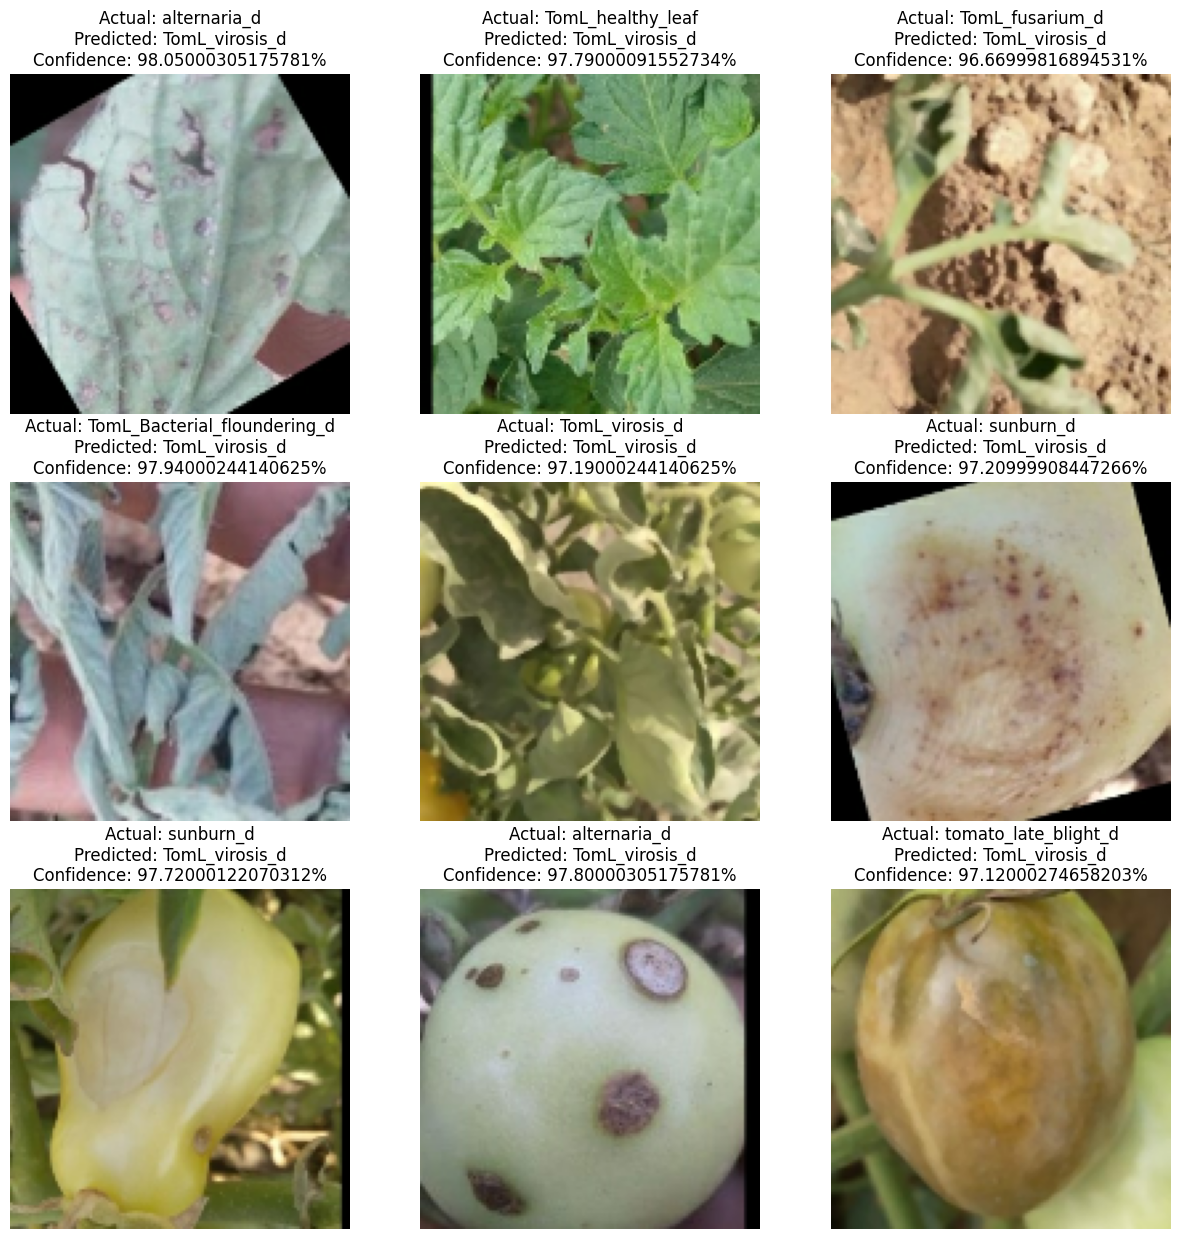

In [68]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Function to predict class and confidence
def predict_image(model, img, class_names):
    """Predict the class and confidence for a single image."""
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)
    predictions = model.predict(img)
    class_index = np.argmax(predictions[0])
    predicted_class = class_names[class_index]
    confidence = round(100 * predictions[0][class_index], 2)
    return predicted_class, confidence

# Function to segment and calculate dead part percentage
def segment_and_calculate_dead_part(img):
    """Segment the image and calculate the percentage of dead parts."""
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask = mask.astype('uint8')
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    dead_area = sum(cv2.contourArea(contour) for contour in contours)
    total_area = img.shape[0] * img.shape[1]
    dead_part_percentage = (dead_area / total_area) * 100 if total_area > 0 else 0
    return dead_part_percentage

# Function to visualize predictions
def visualize_predictions(model, dataset, class_names, num_images=9, segment=False):
    """Visualize predictions with optional segmentation for unhealthy classes."""
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(min(num_images, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            # Denormalize the image if it was normalized [0, 1]
            img = images[i].numpy() * 255 if images[i].numpy().max() <= 1.0 else images[i].numpy()
            img = img.astype("uint8")
            plt.imshow(img)
            predicted_class, confidence = predict_image(model, images[i].numpy(), class_names)
            actual_class = class_names[labels[i]]
            title = f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%"
            healthy_class = next((name for name in class_names if 'healthy' in name.lower() or 'normal' in name.lower()), None)
            if segment and predicted_class != healthy_class and actual_class != healthy_class:
                dead_part_percentage = segment_and_calculate_dead_part(img)
                title += f"\nDead Part: {dead_part_percentage:.2f}%"
                print(f"Image {i+1} Dead Part Percentage: {dead_part_percentage:.2f}%")
            print(f"Image {i+1} Actual class: {actual_class}, Predicted class: {predicted_class}")
            plt.title(title)
            plt.axis("off")
    plt.show()

# Visualize predictions for 9 images without segmentation
visualize_predictions(model, test_ds, class_names, num_images=9, segment=False)

In [69]:
# Evaluate model on test set
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9615 - loss: 0.1611
Validation Accuracy: 96.15%
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9615 - loss: 0.1611
Validation Accuracy: 96.15%


In [70]:
# import shap
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt

# # Load sample batch
# def get_test_batch(test_ds, batch_size=5):
#     for images, labels in test_ds.take(1):
#         return images[:batch_size], labels[:batch_size]

# test_images, test_labels = get_test_batch(test_ds)
# test_images_unnormalized = (test_images.numpy() * 255).astype(np.uint8)

# def generate_shap_explanations(model, X_test, y_test, class_names):
#     def model_predict(x):
#         preds = model(tf.convert_to_tensor(x / 255.0))
#         return preds.numpy()

#     masker = shap.maskers.Image("inpaint_telea", X_test[0].shape)
#     explainer = shap.Explainer(model_predict, masker, output_names=class_names)

#     correct_indices = []
#     for i, image in enumerate(X_test):
#         prediction = model_predict(image[np.newaxis, ...])[0]
#         predicted_class = np.argmax(prediction)
#         true_class_idx = np.argmax(y_test[i])
#         if predicted_class == true_class_idx:
#             correct_indices.append(i)

#     print(f"Number of correctly classified images in batch: {len(correct_indices)}")

#     for idx in correct_indices:
#         image = X_test[idx]
#         true_class_idx = np.argmax(y_test[idx])
#         true_class_name = class_names[true_class_idx]

#         prediction = model_predict(image[np.newaxis, ...])[0]
#         predicted_class = np.argmax(prediction)
#         predicted_prob = prediction[predicted_class]

#         print(f"\nGenerating SHAP explanation for image index {idx} (correctly classified)")
#         print(f"True Class: {true_class_name}")
        
#         # Print prediction probabilities for ALL classes
#         print("Model Prediction Probabilities (all classes):")
#         for i, prob in enumerate(prediction):
#             print(f" - {class_names[i]}: {prob:.4f}")
        
#         print(f"Predicted Class: {class_names[predicted_class]} (Probability: {predicted_prob:.4f})")

#         shap_values = explainer(image[np.newaxis, ...], outputs=shap.Explanation.argsort.flip[:1])

#         plt.figure(figsize=(10, 8))
#         shap.image_plot(shap_values, image[np.newaxis, ...], show=False)

#         plt.suptitle(
#             f"SHAP Explanation for Correct Prediction\nTrue: {true_class_name} | Pred: {class_names[predicted_class]} ({predicted_prob:.2f})",
#             fontsize=14,
#             fontweight='bold'
#         )
#         plt.show()
#         plt.clf()

#     # Combined SHAP for all classes on the first correctly classified image (if any)
#     if len(correct_indices) > 0:
#         idx = correct_indices[0]
#         image = X_test[idx]
#         print(f"\nGenerating combined SHAP explanation for all classes on image index {idx}")

#         shap_values_all = explainer(image[np.newaxis, ...])

#         plt.figure(figsize=(12, 10))
#         shap.image_plot(shap_values_all, image[np.newaxis, ...], show=False)

#         true_class_idx = np.argmax(y_test[idx])
#         true_class_name = class_names[true_class_idx]
#         prediction = model_predict(image[np.newaxis, ...])[0]
#         predicted_class = np.argmax(prediction)
#         predicted_prob = prediction[predicted_class]

#         plt.suptitle(
#             f"Combined SHAP Explanation for All Classes\nTrue: {true_class_name} | Pred: {class_names[predicted_class]} ({predicted_prob:.2f})",
#             fontsize=14,
#             fontweight='bold'
#         )
#         plt.show()
#         plt.clf()
#     else:
#         print("No correctly classified images found in the batch to generate combined SHAP visualization.")

# # Replace with your actual class names list
# # Example: class_names = ['Normal', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

# generate_shap_explanations(model, test_images_unnormalized, test_labels.numpy(), class_names)

# print("✅ SHAP analysis completed for correctly classified images and combined visualization.")


In [71]:
!pip install shap


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [72]:
# import shap
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt

# # Load sample batch
# def get_test_batch(test_ds, batch_size=5):
#     for images, labels in test_ds.take(1):
#         return images[:batch_size], labels[:batch_size]

# test_images, test_labels = get_test_batch(test_ds)
# test_images_unnormalized = (test_images.numpy() * 255).astype(np.uint8)

# def generate_shap_explanations(model, X_test, y_test, class_names):
#     def model_predict(x):
#         # Normalize to [0, 1] before prediction
#         preds = model(tf.convert_to_tensor(x / 255.0))
#         return preds.numpy()

#     # SHAP masker for images
#     masker = shap.maskers.Image("inpaint_telea", X_test[0].shape)

#     # SHAP explainer
#     explainer = shap.Explainer(model_predict, masker, output_names=class_names)

#     # Step 1: Identify correctly classified images only
#     correct_indices = []
#     for i, image in enumerate(X_test):
#         prediction = model_predict(image[np.newaxis, ...])[0]
#         predicted_class = np.argmax(prediction)
#         true_class_idx = np.argmax(y_test[i])
#         if predicted_class == true_class_idx:
#             correct_indices.append(i)

#     print(f"Number of correctly classified images in batch: {len(correct_indices)}")

#     # Step 2: Generate SHAP explanations for correctly classified images
#     for idx in correct_indices:
#         image = X_test[idx]
#         true_class_idx = np.argmax(y_test[idx])
#         true_class_name = class_names[true_class_idx]

#         prediction = model_predict(image[np.newaxis, ...])[0]
#         predicted_class = np.argmax(prediction)
#         predicted_prob = prediction[predicted_class]

#         print(f"\nGenerating SHAP explanation for image index {idx} (correctly classified)")

#         print(f"True Class: {true_class_name}")
#         print("Model Prediction Probabilities:")
#         for i, prob in enumerate(prediction):
#             print(f" - {class_names[i]}: {prob:.4f}")
#         print(f"Predicted Class: {class_names[predicted_class]} (Probability: {predicted_prob:.4f})")

#         # SHAP explanation for the predicted class
#         shap_values = explainer(image[np.newaxis, ...], outputs=shap.Explanation.argsort.flip[:1])

#         plt.figure(figsize=(10, 8))
#         shap.image_plot(shap_values, image[np.newaxis, ...], show=False)

#         plt.suptitle(
#             f"SHAP Explanation for Correct Prediction\nTrue: {true_class_name} | Pred: {class_names[predicted_class]} ({predicted_prob:.2f})",
#             fontsize=14,
#             fontweight='bold'
#         )
#         plt.show()
#         plt.clf()

#     # Step 3: Generate one combined SHAP image for **all classes** on the first correctly classified image (if any)
#     if len(correct_indices) > 0:
#         idx = correct_indices[0]
#         image = X_test[idx]
#         print(f"\nGenerating combined SHAP explanation for all classes on image index {idx}")

#         # Get SHAP values for all classes
#         shap_values_all = explainer(image[np.newaxis, ...])

#         plt.figure(figsize=(12, 10))
#         shap.image_plot(shap_values_all, image[np.newaxis, ...], show=False)

#         true_class_idx = np.argmax(y_test[idx])
#         true_class_name = class_names[true_class_idx]
#         prediction = model_predict(image[np.newaxis, ...])[0]
#         predicted_class = np.argmax(prediction)
#         predicted_prob = prediction[predicted_class]

#         plt.suptitle(
#             f"Combined SHAP Explanation for All Classes\nTrue: {true_class_name} | Pred: {class_names[predicted_class]} ({predicted_prob:.2f})",
#             fontsize=14,
#             fontweight='bold'
#         )
#         plt.show()
#         plt.clf()

#     else:
#         print("No correctly classified images found in the batch to generate combined SHAP visualization.")

# # Replace with your actual class names
# # Example: class_names = ['Normal', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
# generate_shap_explanations(model, test_images_unnormalized, test_labels.numpy(), class_names)

# print("✅ SHAP analysis completed for correctly classified images and combined visualization.")


In [73]:
# # Install SHAP if needed
# # !pip install shap

# import shap
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt

# # Load sample batch
# def get_test_batch(test_ds, batch_size=5):
#     for images, labels in test_ds.take(5):
#         return images[:batch_size], labels[:batch_size]

# test_images, test_labels = get_test_batch(test_ds)
# test_images_unnormalized = (test_images.numpy() * 255).astype(np.uint8)

# # Explanation wrapper
# def generate_shap_explanations(model, X_test, y_test, class_names):
#     def model_predict(x):
#         # Normalize to [0, 1] before prediction
#         preds = model(tf.convert_to_tensor(x / 255.0))
#         return preds.numpy()

#     # SHAP masker
#     masker = shap.maskers.Image("inpaint_telea", X_test[0].shape)

#     # SHAP Explainer
#     explainer = shap.Explainer(model_predict, masker, output_names=class_names)

#     for index, image in enumerate(X_test):
#         print(f"\nGenerating SHAP explanation for image {index + 1}")

#         # Predict class from model
#         prediction = model_predict(image[np.newaxis, ...])[0]
#         predicted_class = np.argmax(prediction)
#         predicted_prob = prediction[predicted_class]
#         true_class_idx = np.argmax(y_test[index])
#         true_class_name = class_names[true_class_idx]

#         print(f"True Class: {true_class_name}")
#         print("Model Prediction Probabilities:")
#         for i, prob in enumerate(prediction):
#             print(f" - {class_names[i]}: {prob:.4f}")
#         print(f"Predicted Class: {class_names[predicted_class]} (Probability: {predicted_prob:.4f})")

#         # SHAP explanation (for predicted class only)
#         shap_values = explainer(image[np.newaxis, ...], outputs=shap.Explanation.argsort.flip[:1])  # top class

#         # Plot SHAP
#         plt.figure(figsize=(10, 8))
#         shap.image_plot(shap_values, image[np.newaxis, ...], show=False)

#         true_label = f"True: {true_class_name}"
#         predicted_label = f"Pred: {class_names[predicted_class]} ({predicted_prob:.2f})"
#         plt.suptitle(f"SHAP Explanation\n{true_label} | {predicted_label}", fontsize=14, fontweight='bold')
#         plt.show()
#         plt.clf()

# # Replace with your actual class names
# # Example: class_names = ['Normal', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
# generate_shap_explanations(model, test_images_unnormalized, test_labels.numpy(), class_names)

# print("✅ SHAP analysis completed for ViT model.")


In [74]:
# # Install LIME if not already installed
# !pip install lime

# # === IMPORTS ===
# from lime import lime_image
# from skimage.segmentation import mark_boundaries
# import matplotlib.pyplot as plt
# import numpy as np

# # === LIME-compatible prediction function ===
# def lime_predict(images):
#     images = np.array(images) / 255.0  # Normalize to [0,1]
#     predictions = model.predict(images)  # Returns softmax probs
#     return predictions

# # === Initialize LIME image explainer ===
# explainer = lime_image.LimeImageExplainer()

# # === Loop over a few test images ===
# # Display image with positive (green) and negative (red) contributions
# for index in range(3):
#     image = test_images_unnormalized[index]
#     label = np.argmax(test_labels[index])
    
#     print(f"\n🔍 Explaining image {index + 1} - True class: {class_names[label]}")
    
#     explanation = explainer.explain_instance(
#         image=image,
#         classifier_fn=lime_predict,
#         top_labels=5,
#         hide_color=0,
#         num_samples=1000
#     )

#     predicted_class = explanation.top_labels[0]

#     # Get image with positive and negative contributions separately
#     for positive_only in [True, False]:
#         temp, mask = explanation.get_image_and_mask(
#             label=predicted_class,
#             positive_only=positive_only,   # True = only green; False = both red/green
#             num_features=10,
#             hide_rest=False
#         )

#         title_type = "Positive Only" if positive_only else "Positive + Negative"

#         plt.figure(figsize=(8, 6))
#         plt.imshow(mark_boundaries(temp / 255.0, mask))
#         plt.title(
#             f"LIME ({title_type})\nTrue: {class_names[label]} | Pred: {class_names[predicted_class]}",
#             fontsize=12, fontweight='bold'
#         )
#         plt.axis('off')
#         plt.show()


In [75]:
# # Install LIME if not already installed
# # !pip install lime

# from lime import lime_image
# from skimage.segmentation import mark_boundaries
# import matplotlib.pyplot as plt
# import numpy as np

# def lime_predict(images):
#     images = np.array(images) / 255.0  # Normalize to [0,1]
#     predictions = model.predict(images)  # Returns softmax probs
#     return predictions

# explainer = lime_image.LimeImageExplainer()

# # Only explain correctly classified images (from test batch)
# correct_indices = []
# for i, image in enumerate(test_images_unnormalized):
#     prediction = lime_predict(image[np.newaxis, ...])[0]
#     predicted_class = np.argmax(prediction)
#     true_class = np.argmax(test_labels[i])
#     if predicted_class == true_class:
#         correct_indices.append(i)

# print(f"Number of correctly classified images in test batch: {len(correct_indices)}")

# # Limit to max 3 explanations to keep it concise
# for idx in correct_indices[:3]:
#     image = test_images_unnormalized[idx]
#     true_class_idx = np.argmax(test_labels[idx])
#     true_class_name = class_names[true_class_idx]
#     pred_probs = lime_predict(image[np.newaxis, ...])[0]
#     predicted_class = np.argmax(pred_probs)
#     predicted_class_name = class_names[predicted_class]

#     print(f"\n🔍 Explaining image index {idx} - True: {true_class_name}, Predicted: {predicted_class_name}")

#     explanation = explainer.explain_instance(
#         image=image,
#         classifier_fn=lime_predict,
#         top_labels=5,
#         hide_color=0,
#         num_samples=1000
#     )

#     # Plot positive only and positive+negative side-by-side
#     plt.figure(figsize=(12, 6))

#     for i, positive_only in enumerate([True, False], start=1):
#         temp, mask = explanation.get_image_and_mask(
#             label=predicted_class,
#             positive_only=positive_only,
#             num_features=10,
#             hide_rest=False
#         )
#         title_type = "Positive Only" if positive_only else "Positive + Negative"
#         plt.subplot(1, 2, i)
#         plt.imshow(mark_boundaries(temp / 255.0, mask))
#         plt.title(f"LIME ({title_type})\nTrue: {true_class_name} | Pred: {predicted_class_name}", fontsize=12, fontweight='bold')
#         plt.axis('off')

#     plt.show()


In [ ]:
import os

# Save ViT model weights for backend use
model_save_dir = os.path.join("D:", "Tomwebapp", "agri-app", "backend", "app", "models")
os.makedirs(model_save_dir, exist_ok=True)
model.save_weights(os.path.join(model_save_dir, "vitMaize_model.weights.h5"))
print("Model weights saved to:", os.path.join(model_save_dir, "vitMaize_model.weights.h5"))

Model weights saved to: D:Tomwebapp\agri-app\backend\app\models\vitTomatoo_model.weights.h5
